# Load and preprocess images

This tutorial shows how to load and preprocess an image dataset in three ways:

- First, you will use high-level Keras preprocessing utilities (such as `tf.keras.utils.image_dataset_from_directory`) and layers (such as `tf.keras.layers.Rescaling`) to read a directory of images on disk.
- Next, you will write your own input pipeline from scratch using tf.data.
- Finally, you will download a dataset from the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) available in [TensorFlow Datasets](https://www.tensorflow.org/datasets).

## Setup

In [1]:
import numpy as np
import os
import PIL
import glob
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.15.0


### Download the flowers dataset

This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains five sub-directories, one per class:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

228813984/228813984 [==============================] - 6s 0us/step


In [4]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

After downloading (218MB), you should now have a copy of the flower photos available. There are 3,670 total images:

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [6]:
len(glob.glob(os.path.join(data_dir, '*/*.jpg')))

3670

Each directory contains images of that type of flower. Here are some roses:

In [7]:
os.listdir(str(data_dir))

['tulips', 'dandelion', 'LICENSE.txt', 'sunflowers', 'daisy', 'roses']

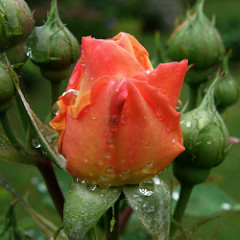

In [8]:
rose_path = os.path.join(data_dir, 'roses/*.jpg')
roses_1 = list(glob.glob(rose_path))
PIL.Image.open(roses_1[3])

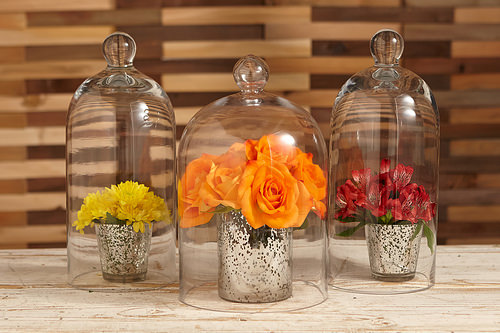

In [9]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

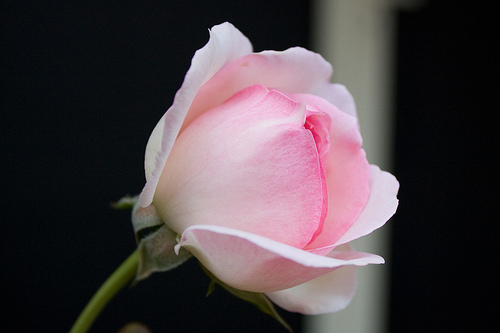

In [10]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## Load data using a Keras utility

### Create a dataset

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model.

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data

Here are the first nine images from the training dataset.

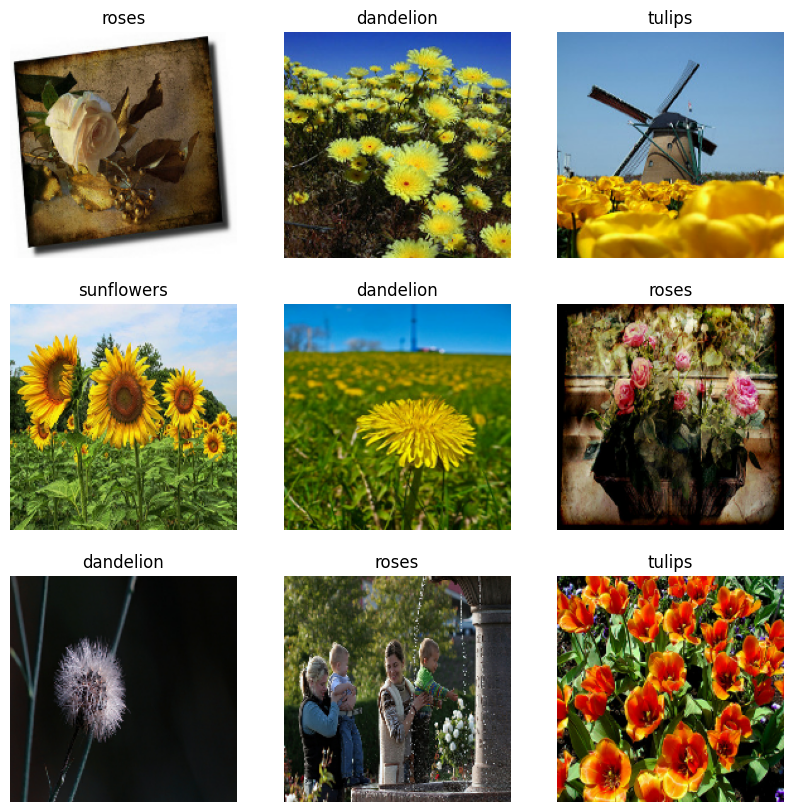

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3`. The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

### Standardize the data


In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


Or the layer can be included inside the model definition to simplify deployment.

Note: scale pixel values to `[-1,1]` = `tf.keras.layers.Rescaling(1./127.5, offset=-1)`

Note: the resizing logic in your model = `tf.keras.layers.Resizing` layer.

### Configure the dataset for performance

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

In [20]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [21]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [22]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 146s 2s/step - loss: 1.3054 - accuracy: 0.4499 - val_loss: 1.1174 - val_accuracy: 0.5490
Epoch 2/3
92/92 [==============================] - 129s 1s/step - loss: 1.0467 - accuracy: 0.5875 - val_loss: 0.9936 - val_accuracy: 0.6185
Epoch 3/3
92/92 [==============================] - 122s 1s/step - loss: 0.9024 - accuracy: 0.6468 - val_loss: 0.9506 - val_accuracy: 0.6253


## Using tf.data for finer control

The above Keras preprocessing utility—`tf.keras.utils.image_dataset_from_directory`—is a convenient way to create a `tf.data.Dataset` from a directory of images.

For finer grain control, you can write your own input pipeline using `tf.data`. This section shows how to do just that, beginning with the file paths from the TGZ file you downloaded earlier.

In [27]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [57]:
for f in list_ds.take(5):
  print(f)
  parts = tf.strings.split(f, os.path.sep)
  one_hot = parts[-2] == class_names
  print(tf.argmax(one_hot))

tf.Tensor(b'/root/.keras/datasets/flower_photos/dandelion/7116950607_49b19102ba_n.jpg', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'/root/.keras/datasets/flower_photos/sunflowers/9783416751_b2a03920f7_n.jpg', shape=(), dtype=string)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(b'/root/.keras/datasets/flower_photos/dandelion/14076873230_d0bd53b220.jpg', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'/root/.keras/datasets/flower_photos/tulips/5674127693_1ddbd81097.jpg', shape=(), dtype=string)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(b'/root/.keras/datasets/flower_photos/dandelion/14053397367_75cba846eb_n.jpg', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


The tree structure of the files can be used to compile a `class_names` list.

In [35]:
list(data_dir.glob("*"))

[PosixPath('/root/.keras/datasets/flower_photos/tulips'),
 PosixPath('/root/.keras/datasets/flower_photos/dandelion'),
 PosixPath('/root/.keras/datasets/flower_photos/LICENSE.txt'),
 PosixPath('/root/.keras/datasets/flower_photos/sunflowers'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy'),
 PosixPath('/root/.keras/datasets/flower_photos/roses')]

In [36]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Split the dataset into training and validation sets:

In [37]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

the length of each dataset as follows:

In [41]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


A short function that converts a file path to an `(img, label)` pair:

In [61]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [63]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [64]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [65]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [66]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


### Configure dataset for performance

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

In [67]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Visualize the data

You can visualize this dataset similarly to the one you created previously:

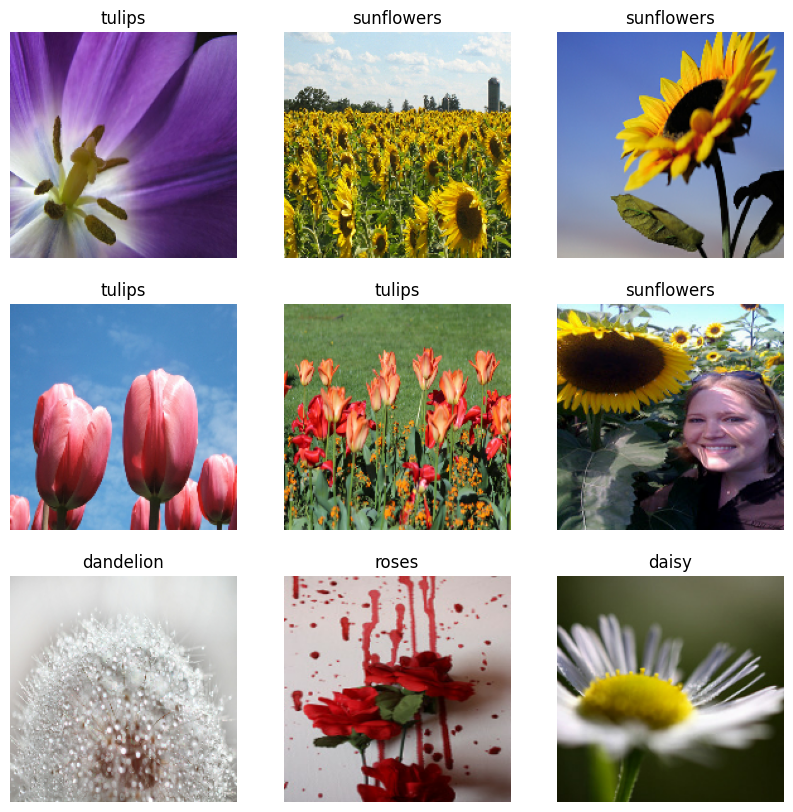

In [68]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Training the modele running time short.

In [69]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 163s 2s/step - loss: 0.7719 - accuracy: 0.7010 - val_loss: 0.7632 - val_accuracy: 0.7071
Epoch 2/3
92/92 [==============================] - 134s 1s/step - loss: 0.6166 - accuracy: 0.7694 - val_loss: 0.7785 - val_accuracy: 0.6962
Epoch 3/3
92/92 [==============================] - 133s 1s/step - loss: 0.4498 - accuracy: 0.8372 - val_loss: 0.7963 - val_accuracy: 0.6989


## Using TensorFlow Datasets

So far, this tutorial has focused on loading data off disk. A dataset can be found to use by exploring the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) of easy-to-download datasets at [TensorFlow Datasets](https://www.tensorflow.org/datasets).

Download the Flowers [dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) using TensorFlow Datasets:

In [70]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


The flowers dataset has five classes:

In [71]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


 Retrieve an image from the dataset:

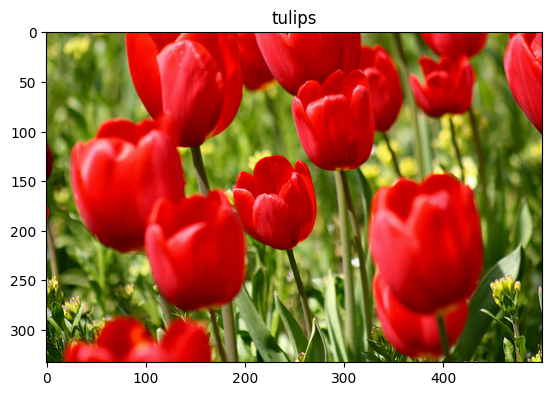

In [72]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

As before, remember to batch, shuffle, and configure the training, validation, and test sets for performance:

In [73]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)